In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd # For csv
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import collections
import requests
import pickle

## Protein Disorder Prediction

### Data set-up

Import drive, so that DisProt.tsv can be read (assuming downloaded). Future adaption to use API to request TSV.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Amino Acids Channeled Image

In [3]:
def make_empty_image(seq):
  img = {
    'A' : np.zeros(len(seq)),
    'C' : np.zeros(len(seq)),
    'D' : np.zeros(len(seq)),
    'E' : np.zeros(len(seq)),
    'F' : np.zeros(len(seq)),
    'G' : np.zeros(len(seq)),
    'H' : np.zeros(len(seq)),
    'I' : np.zeros(len(seq)),
    'K' : np.zeros(len(seq)),
    'L' : np.zeros(len(seq)),
    'M' : np.zeros(len(seq)),
    'N' : np.zeros(len(seq)),
    'P' : np.zeros(len(seq)),
    'Q' : np.zeros(len(seq)),
    'R' : np.zeros(len(seq)),
    'S' : np.zeros(len(seq)),
    'T' : np.zeros(len(seq)),
    'V' : np.zeros(len(seq)),
    'W' : np.zeros(len(seq)),
    'Y' : np.zeros(len(seq))
  }
  return img

def make_image(seq):
  # Makes 20 empty channels
  channeled_img = make_empty_image(seq)
  # Loop over each amino acid in the sequence - 
  # for its position add a 1 to the letter identifier channel
  for i, char in enumerate(seq):
    # Updates array due to arrays being like pointers
    channeled_img.get(char)[i] = 1

  return channeled_img

In [4]:
# Data from DisProt TSV - https://disprot.org/download
data_disprot = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DL-DISS/DisProt_v1.tsv', sep='\t')

In [5]:
# Dictionary for important data from DisProt
disorder_start_and_end = {}

for i, acc in enumerate(data_disprot['acc']):
  s = data_disprot['start'][i]
  e = data_disprot['end'][i]
  arr = disorder_start_and_end.get((str(acc)), [])

  if (s, e) not in arr:
    disorder_start_and_end[str(acc)] = arr + [(s, e)]


In [6]:
# Create new table for important DisProt data
data = {'acc': disorder_start_and_end.keys(), 'disordered_regions': disorder_start_and_end.values()}

In [7]:
pd.DataFrame.from_dict(data)

,acc,disordered_regions
0,P03265,"[(294, 334), (454, 464)]"
1,P49913,"[(134, 170)]"
2,P03045,"[(1, 107), (1, 22), (34, 47), (1, 36)]"
3,P00004,"[(1, 104), (2, 105)]"
4,P27695,"[(1, 42), (1, 36), (32, 43), (2, 40)]"
...,...,...
2414,A0A5P2U9X4,"[(350, 525), (460, 521), (417, 426), (450, 525)]"
2415,P40939,"[(637, 647)]"
2416,Q6CSX2,"[(562, 831)]"
2417,Q8IYT8,"[(168, 177)]"


In [8]:
pandas_data = pd.DataFrame.from_dict(data)

The proteins in this dataframe are preprocessed to get their full sequences from UniProt.

In [ ]:
# Preprocessing - download all sequences.
def preprocess_sequences(pandas_data):
  protSeqDict = {}
  for row in range(len(pandas_data)):
    acc = pandas_data['acc'].loc[row]

    url = f'https://www.uniprot.org/uniprotkb/{str(acc)}.fasta'
    uniprot_fasta = requests.get(url).text
    # Gets the sequence as a string of amino acids
    protein_sequence = uniprot_fasta.split('\n')[1:]
    protein_sequence = ''.join(protein_sequence)

    if protein_sequence == '':
      continue

    protSeqDict[acc] = protein_sequence
  return protSeqDict

protein_sequences_n_ids = preprocess_sequences(pandas_data)

In [ ]:
with open('/content/drive/My Drive/Colab Notebooks/DL-DISS/uniSeqData.txt', 'wb') as outfile:
    pickle.dump(protein_sequences_n_ids, outfile)

Quick access to preprocessed data, instead of downloading it each time Notebook is opened.

In [9]:
with open('/content/drive/My Drive/Colab Notebooks/DL-DISS/uniSeqData.txt', 'rb') as infile:
    protein_sequences_n_ids = pickle.load(infile)

Removing protein data that is incompatible with my solution.

In [10]:
clean_pandas_data = pandas_data
x = protein_sequences_n_ids.keys()
for acc in pandas_data['acc']:
  if acc in x:
    continue
  else:
    index_to_drop = clean_pandas_data[clean_pandas_data['acc'] == acc].index.tolist()[0]
    clean_pandas_data = clean_pandas_data.drop(index_to_drop)

In [11]:
for acc in clean_pandas_data['acc']:
  seqq = protein_sequences_n_ids.get(acc)
  if 'X' in seqq or 'U' in seqq or 'Z' in seqq:
    index_to_drop = clean_pandas_data[clean_pandas_data['acc'] == acc].index.tolist()[0]
    clean_pandas_data = clean_pandas_data.drop(index_to_drop)

print(len(clean_pandas_data))

2409


In [12]:
clean_data = {'acc': (clean_pandas_data['acc'].tolist()), 'disordered_regions': (clean_pandas_data['disordered_regions'].tolist())}
fully_clean_pandas_data = pd.DataFrame.from_dict(clean_data)

### Dataset class for our data. 
- Takes in pandas data (usually full TSV).
- The amino acid vectorising map.
- A dictionary mapping protein accession numbers to their sequence (generated from preprocessing).

In [13]:
class DisProtDataset(Dataset):
    def __init__(self, pandas_table, amino_map, protein_sequences, transform=None):
        self.disorder_prot = pandas_table
        self.sequence_map = make_image
        self.sequences = protein_sequences
        self.tranform = transform

    def __len__(self):
        return len(self.disorder_prot)

    def __getitem__(self, idx):
        # Protein accession number - key identifier
        acc = self.disorder_prot['acc'].loc[idx]
        idrs = self.disorder_prot['disordered_regions'].loc[idx]
        
        # Get sequence
        protein_sequence = self.sequences.get(acc)
        # Vectorise amino acids
        protein_sequence_image = self.sequence_map(protein_sequence)
        # Converts channel dictionary to 2D array
        protein_sequence_image = np.array(list(protein_sequence_image.values()))
        
        # Create order/disorder label
        disorder_label = np.zeros(len(protein_sequence))
        for (start, end) in idrs:
          disorder_label[start-1:end] = 1

        get_dict = {'acc': acc, 'image': protein_sequence_image, 'label': disorder_label}
        return get_dict

### Working with a PyTorch NN. RNN model

In [19]:
class RNN_Net(nn.Module):
    def __init__(self):
        super().__init__()
        # 20 inputs - for each amino acid
        self.input_dim = 20
        self.hidden_dim = 10
        self.num_layers = 2
        self.rnn1 = nn.LSTM(input_size=20, hidden_size=self.hidden_dim, num_layers=self.num_layers, batch_first=True)
        self.relu1 = nn.ReLU()
        self.linear = nn.Linear(10, 1)
        self.sig1 = nn.Sigmoid()

    def init_hidden(self, batch_size):
        # Initialise hidden state
        return (torch.zeros(self.num_layers, batch_size, self.hidden_dim).cuda(), 
                torch.zeros(self.num_layers, batch_size, self.hidden_dim).cuda())

    def forward(self, x):
      batch_size = x.size(0)
      h    = self.init_hidden(batch_size)
      y, h = self.rnn1(x,h)

      y = self.relu1(y)
      
      y = self.sig1(self.linear(y))
      
      return y, h

### Training model, given DisProt dataset

Separate train/validation/test datasets. Currently using a 60/20/20 in place split from generated pandas data.

In [20]:
randomly_sampled_pandas_data = fully_clean_pandas_data.sample(frac = 1).reset_index()

train_len = round(len(randomly_sampled_pandas_data) * (60/100))
train_pandas_data = randomly_sampled_pandas_data[0:train_len]
train_dataset = DisProtDataset(train_pandas_data, make_image, protein_sequences_n_ids)

valid_len = round((len(randomly_sampled_pandas_data) * (20/100)))
valid_pandas_data = randomly_sampled_pandas_data[train_len:(train_len+valid_len)]
# Reset index helps clean up index column after slicing.
valid_pandas_data = valid_pandas_data.reset_index(drop=True)
validation_dataset = DisProtDataset(valid_pandas_data, make_image, protein_sequences_n_ids)

test_len = len(randomly_sampled_pandas_data) - (train_len + valid_len)
test_pandas_data = randomly_sampled_pandas_data[(train_len+valid_len):]
test_pandas_data = test_pandas_data.reset_index(drop=True)
test_dataset = DisProtDataset(test_pandas_data, make_image, protein_sequences_n_ids)

train_loader = DataLoader(train_dataset, batch_size=1,
                        shuffle=True, num_workers=0)

validation_loader = DataLoader(validation_dataset, batch_size=1,
                        shuffle=True, num_workers=0)

test_loader = DataLoader(test_dataset, batch_size=1,
                        shuffle=True, num_workers=0)

In [21]:
import datetime
epoch_print_gap = 20

def train_loop_rnn(n_epochs, optimizer, model, loss_fn, train_loader, device):
    model = model.to(device)
    for epoch in range(0, n_epochs):
        
        running_loss_train = 0.0
        total_epoch_loss = 0.0

        # Creating an iterator jumbles the sequences order, so each accumulated batch will consider different 
        # sequences over many epochs
        train_iter = iter(train_loader)

        # Where i is a counter and sam is a dictionary
        for i, sam in enumerate(train_iter):
          acc, image, label = sam.values()
          # Einsum to flip axis dimensions suitable to rnn input
          image = torch.einsum('ijk->ikj', image)
          NN_input = image.type(torch.FloatTensor)
          NN_input = NN_input.to(device)
          expected_output = label.type(torch.FloatTensor)
          expected_output = expected_output.to(device)

          output, _ = model(NN_input)
          squeezed_o = torch.squeeze(output)
          squeezed_e_o = torch.squeeze(expected_output)

          loss = loss_fn(squeezed_o, squeezed_e_o)          
          loss.backward()
          running_loss_train += loss.item()
          total_epoch_loss += loss.item()

          # This has effect of batches of size 16.
          # Don't have just i as when i is 0, this is true, therefore use i+1 and divisor 17.
          if (i+1) % 17 == 0:
            optimizer.step()
            optimizer.zero_grad()
          
          # Print loss throughout epoch.
          # Shows loss per 400 sequences of each epoch.
          # Only prints on print gap
          if epoch % epoch_print_gap == 0:
            if (i+1) % 400 == 0:
              print("Epoch: "+str(epoch), end=" ")
              # Average loss over these 400 sequences
              print("Current loss: "+str(running_loss_train / 400))
              running_loss_train = 0.0

        # Separates printed epochs
        if epoch == 0 or epoch % epoch_print_gap == 0:
            print("Epoch", epoch, "Done \n\n")

        epoch_loss_arr.append( (total_epoch_loss / len(train_loader)) )

# Main
lamb=0.001    # L2 weight decay term
lr = 0.001
epochs = 100
new_model = RNN_Net()
optimizer = optim.SGD(new_model.parameters(), lr=lr, momentum=0.9, weight_decay=lamb)
criterion = nn.BCELoss()
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

epoch_loss_arr = []
train_loop_rnn(epochs, optimizer, new_model, criterion, train_loader, device)


Epoch: 0 Current loss: 0.6896546240150928
Epoch: 0 Current loss: 0.5745471599698067
Epoch: 0 Current loss: 0.5749326700717211
Epoch 0 Done 


Epoch: 20 Current loss: 0.571617911607027
Epoch: 20 Current loss: 0.5905393749475479
Epoch: 20 Current loss: 0.5661952903866768
Epoch 20 Done 


Epoch: 40 Current loss: 0.5893695233017207
Epoch: 40 Current loss: 0.5608968137204647
Epoch: 40 Current loss: 0.5506699424237013
Epoch 40 Done 


Epoch: 60 Current loss: 0.5201802813634276
Epoch: 60 Current loss: 0.5263256292790175
Epoch: 60 Current loss: 0.5429498560726642
Epoch 60 Done 


Epoch: 80 Current loss: 0.5208846875280142
Epoch: 80 Current loss: 0.527132170908153
Epoch: 80 Current loss: 0.5082150420546532
Epoch 80 Done 




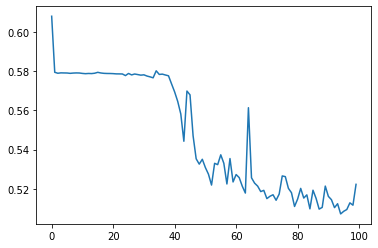

In [22]:
plt.plot(range(100), epoch_loss_arr)
plt.show()

In [23]:
# Turns the prediction to a list of ordered/disordered codes
def pred_round(predicted_label):
  pred_lab = []
  for val in predicted_label:
    if val > 0.5:
      pred_lab.append(1)
    else:
      pred_lab.append(0)

  pred_lab = np.array(pred_lab)
  return pred_lab

def calc_MCC(prediction, true_label):
  TP = FP = TN = FN = 0
  for i, pred in enumerate(prediction):
    labelled_index = true_label[i]
    if pred == 0:
      if labelled_index == 0:
        TN += 1
      else: # label is 1
        FN += 1
    else: # prediction is 1
      if labelled_index == 1:
        TP += 1
      else: # label is 0
        FP += 1

  #print("TP: ",TP,"\nFP: ",FP,"\nTN: ",TN,"\nFN: ",FN)
  num = (TP * TN) - (FP * FN)
  den = np.sqrt( ( (TP+FP)*(TP+FN)*(TN+FP)*(TN+FN) ) )
  if den == 0:
    return 0
  MCC = num / den
  #print("MCC: ",MCC)
  return MCC

In [24]:
test_mcc_score = 0

for i, sm in enumerate(test_loader):
  #print(sm)
  im = sm.get('image')
  im = torch.einsum('ijk->ikj', im)
  im = im.type(torch.FloatTensor)
  im = im.to(device)
  #print(im)

  true_label = sm.get('label')
  true_label = true_label[0].numpy()
  
  with torch.no_grad():
    predicted_label, _ = new_model(im)

  predicted_label = torch.squeeze(predicted_label)
  pred_lab = pred_round(predicted_label)

  test_mcc_score += calc_MCC(pred_lab, true_label)

In [28]:
# Average MCC on test dataset
test_mcc_score / len(test_loader)

0.028747111531001412